# Google Contrails Forecasts

The [Google Contrails API](https://developers.google.com/contrails) provides a global contrail forecast free of charge.

To access the Contrails API, use an [API key](https://console.cloud.google.com/apis/credentials) from a GCP project with the [Contrails API enabled](https://console.cloud.google.com/apis/library/contrails.googleapis.com). Then, set the `GOOGLE_API_KEY` environment variable to the API key or provide it in the constructor `GoogleForecast(key='YOUR_API_KEY')`.

Alternatively, you can use any [google-auth](https://pypi.org/project/google-auth/) credentials, e.g. run `gcloud auth application-default login` to authenticate on your local machine.

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

from pycontrails.core.flight import Flight
from pycontrails.datalib.google_forecast import (
    ExpectedEffectiveEnergyForcing,
    GoogleForecast,
    Severity,
)

# Download the Google Contrails forecast for 24h into the future

Request the `Severity` variable for a simple scale from 0 (no warming) to 4 (severe warming). Alternatively, request `ExpectedEffectiveEnergyForcing` for the expected, effective energy forcing in J/m. See the [Google Contrails documentation](https://developers.google.com/contrails/v1/forecast-data) for more details.

In [ ]:
gf = GoogleForecast(
    # The API provides hourly forecasts, e.g. +24h into the future.
    time=(pd.Timestamp.now() + pd.Timedelta("24h")).floor("h"),
    variables=(Severity),  # Also supports ExpectedEffectiveEnergyForcing.
    # key="YOUR_API_KEY",  # Optional if GOOGLE_API_KEY env var is set
)

met = gf.open_metdataset()
met

MetDataset with data:

<xarray.Dataset> Size: 75MB
Dimensions:                  (longitude: 1441, latitude: 721, level: 18, time: 1)
Coordinates:
  * longitude                (longitude) float64 12kB -180.0 -179.8 ... 180.0
  * latitude                 (latitude) float64 6kB -90.0 -89.75 ... 89.75 90.0
  * level                    (level) float64 144B 154.7 162.4 ... 329.3 344.3
  * time                     (time) datetime64[ns] 8B 2026-02-12T11:00:00
    flight_level             (level) int16 36B 440 430 420 410 ... 290 280 270
    forecast_reference_time  (time) datetime64[ns] 8B 2026-02-11T09:00:00
    air_pressure             (level) float32 72B 1.547e+04 ... 3.443e+04
    altitude                 (level) float32 72B 1.341e+04 ... 8.23e+03
Data variables:
    contrails                (longitude, latitude, level, time) float32 75MB ...
Attributes:
    inference_pipeline_version:  contrails.forecast-pipeline_20260129.02_p0
    api_version:                 contrails.api-service_20260209.02_p0
    aircraft_class:              default
    provider:                    Google
    dataset:                     Contrails Forecast
    product:                     forecast

# Plot the forecasted contrail impact

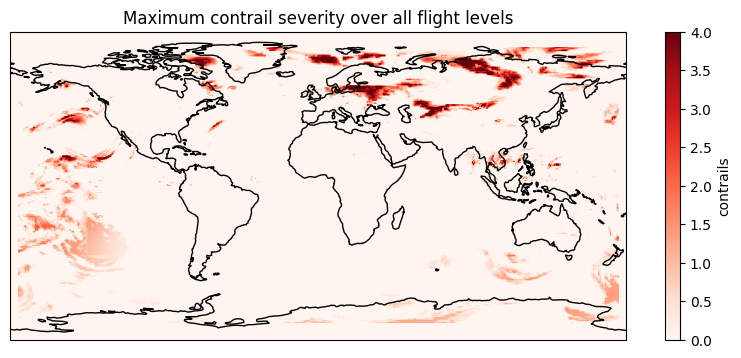

In [ ]:
severity_da = met.data["contrails"].isel(time=0).max(dim="level")
p = severity_da.plot(
    x="longitude",
    y="latitude",
    cmap="Reds",
    subplot_kws=dict(projection=ccrs.PlateCarree(), transform=ccrs.PlateCarree()),
    figsize=(10, 4),
)
p.axes.coastlines()
plt.title("Maximum contrail severity over all flight levels");

# Check the forecast for a specific flight trajectory

In [49]:
# Load a sample flight.
df = pd.read_csv("../notebooks/data/flight-ap.csv")
df["time"] = pd.to_datetime(df["time"])

# Hack: Because the sample flight is too far in the past, we "move" it to a more recent date.
# This is for demo purposes only and doesn't need to be done with any real flight plan!
df["time"] += pd.Timedelta(days=500)

f = Flight(df)
f

Flight [4 keys x 130 length, 0 attributes]
	Keys: longitude, latitude, altitude, time
	Attributes:
	time                [2025-01-04 20:07:00, 2025-01-04 22:16:00]
	longitude           [-97.01, -83.352]
	latitude            [32.903, 42.229]
	altitude            [190.5, 11582.4]

## Load the forecast for the entire flight duration

In [ ]:
# The forecast is provided hourly, so we round down the departure time, round up the arrival time, and load all hours inbetween.
global_mds = GoogleForecast(
    [f.time_start.floor("h"), f.time_end.ceil("h")], variables=ExpectedEffectiveEnergyForcing
).open_metdataset()
global_mds

MetDataset with data:

<xarray.Dataset> Size: 299MB
Dimensions:                            (longitude: 1441, latitude: 721,
                                        level: 18, time: 4)
Coordinates:
  * longitude                          (longitude) float64 12kB -180.0 ... 180.0
  * latitude                           (latitude) float64 6kB -90.0 ... 90.0
  * level                              (level) float64 144B 154.7 ... 344.3
  * time                               (time) datetime64[ns] 32B 2025-01-04T2...
    flight_level                       (level) int16 36B 440 430 420 ... 280 270
    forecast_reference_time            (time) datetime64[ns] 32B 2026-02-05T0...
    air_pressure                       (level) float32 72B 1.547e+04 ... 3.44...
    altitude                           (level) float32 72B 1.341e+04 ... 8.23...
Data variables:
    expected_effective_energy_forcing  (longitude, latitude, level, time) float32 299MB ...
Attributes:
    inference_pipeline_version:  contrails.forecast-pipeline_20260129.02_p0
    api_version:                 contrails.api-service_20260209.02_p0
    aircraft_class:              default
    provider:                    Google
    dataset:                     Contrails Forecast
    product:                     forecast

## Intersect the forecast with the flight trajectory

In [ ]:
f = f.clean_and_resample()
f["eeef_per_m"] = f.intersect_met(
    global_mds["expected_effective_energy_forcing"], method="linear", fill_value=0.0
)
pd.DataFrame(f["eeef_per_m"], columns=["eeef_per_m"]).describe()

,eeef_per_m
count,1.300000e+02
mean,4.886437e+05
std,8.505285e+05
min,0.000000e+00
25%,0.000000e+00
50%,5.245293e+04
75%,5.177957e+05
max,4.006021e+06


## Plot the expected effective energy forcing for the flight's vertical profile

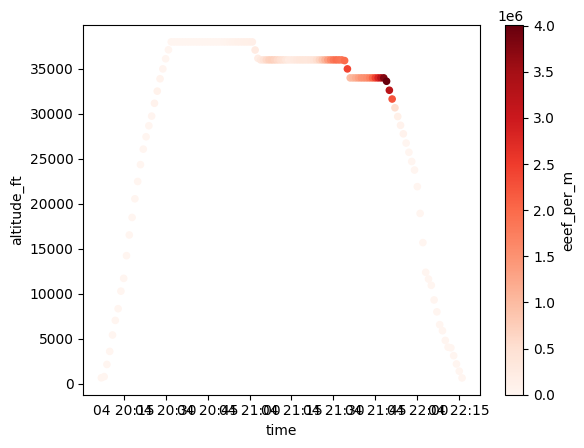

In [48]:
f.plot_profile(kind="scatter", c="eeef_per_m", cmap="Reds");